In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Path to the data folders
raw_data_folder = '../data/RAW/'
clean_data_folder = '../data/CLEAN/'

## First: we loead the dataset (always run this one first and then jump down to 2 DIRECTLY)

In [51]:
# Load the movie metadata
CMU_movie_metadata = pd.read_csv(raw_data_folder+'CMU_Movies_Dataset/movie.metadata.tsv', delimiter='\t', header=None)
CMU_movie_metadata.columns = ['wikipedia_movie_ID', 'freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
#display(CMU_movie_metadata.head(10))

# Load the plot summaries
CMU_plot_summary = pd.read_csv(raw_data_folder+'CMU_Movies_Dataset/plot_summaries.txt', sep='\t', header=None)
CMU_plot_summary.columns = ['wikipedia_movie_ID', 'plot_summary']

## 0: Here's Emma playground, go to section 1 for serious stuff

In [39]:
#display(CMU_movie_metadata)
display(CMU_plot_summary)

display(CMU_plot_summary['plot_summary'][34])
print(CMU_plot_summary['wikipedia_movie_ID'][34])

,wikipedia_movie_ID,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


'In 1942, a 10 year old boy named Timmy plays with a jigsaw puzzle of a nude woman when his mother walks in. She chastises him for it. The mother orders Timmy to get a plastic bag because "I\'m gonna burn everything." Timmy gruesomely murders her with an axe instead of getting the plastic bag. The police later arrive at the house and Timmy is finishing the puzzle. The police break into the house through the front door. Timmy then hides in one of the closets. The police then enter into the bedroom, they find a bloody mess all over the room and also find the mother\'s head inside one of the closets. The police hear Timmy weeping in the another closet, so they open the door and find him covered in blood. The police question the whereabouts of the father; the nanny replies hesitantly and lying obviously that he is in Europe with the Air Force, but the nanny also says that Timmy has an aunt, who lives an hour away and also the nanny says that she will call Timmy\'s aunt and that the nanny w

8471210


In [6]:
#type(CMU_plot_summary['plot_summary'][34]) to find out the type, Emma
my_string = CMU_plot_summary['plot_summary'][34]

my_string = CMU_plot_summary['plot_summary'][0]
print(my_string)
my_string.count("bizarre")

Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.


1

In [40]:
# ici c'est juste un test, pour voir si ça marche. voir prochaine cellule pour du sérieux
violent_words_list = ["acid", "aggressor", "agitator", "aim", "alert", "ambush", "ammunition", "anarchy", "anguish", "annihilate", "nude"]

CMU_plot_summary['plot_summary'].apply(lambda x: x.lower().count(violent_words_list[10]))

0        0
1        0
2        0
3        0
4        0
        ..
42298    0
42299    0
42300    0
42301    0
42302    0
Name: plot_summary, Length: 42303, dtype: int64

In [4]:
# voilà, ici c'est du sérieux
findings = pd.DataFrame()

violent_words_list = [
    "acid", "aggressor", "agitator", "aim", "alert", "ambush", "ammunition", "anarchy", "anguish", 
    "annihilate", "apartheid", "arms", "arsenal", "artillery", "assassin", "assassinate", "assault", 
    "atrocity", "attack", "authority", "automatic", "barrage", "barricade", "battle", "battlefield", 
    "belligerent", "betrayal", "blast", "blindside", "blood", "bloody", "bomb", "bombardment", 
    "booby trap", "breach", "break", "brutal", "brutality", "brute", "bullet", "bully", "burn", 
    "cadaver", "camouflage", "campaign", "captive", "capture", "careen", "carnage", "casualties", 
    "cataclysm", "causes", "chaos", "charge", "charred", "checking", "clandestine", "clash", "coalition", 
    "collapse", "combat", "commandos", "concentration", "concussion", "conflagration", "conflict", 
    "confrontation", "conquer", "consequences", "consolidate", "conspiracy", "conspire", "control", 
    "coordinates", "corpse", "counterattack", "countermand", "crash", "crime", "crisis", "cross-hairs", 
    "culpability", "damage", "danger", "dangerous", "dash", "dead", "deadly", "death", "debacle", 
    "deception", "deliberate", "demolish", "demoralize", "despot", "destroy", "destruction", "detect", 
    "detection", "devastation", "device", "dictator", "dictatorship", "die", "disarmament", "disaster", 
    "disastrous", "discipline", "disease", "dispute", "disruption", "dissonance", "division", "domination", 
    "doom", "downfall", "drama", "dread", "encounter", "enemy", "enforce", "engagement", "epithet", 
    "escalate", "excess", "execute", "execution", "expectations", "explode", "exploitation", "explosion", 
    "explosive", "expunge", "extremism", "faction", "fanatic", "fatal", "fear", "fearful", "felon", 
    "ferment", "ferocious", "feud", "fierce", "fiery", "fight", "fighter", "force", "forceful", "forces", 
    "fray", "frenzy", "front lines", "fuel", "fugitive", "furtive", "gang", "gang up on", "gas", 
    "genocide", "germ warfare", "grave", "grenade", "grievous", "groans", "guard", "guerrillas", 
    "guided bombs", "guns", "gunship", "hammering", "harass", "harsh", "hatch", "hate", "hatred", 
    "hazard", "hiding", "hijack", "hijacker", "hit", "hit-and-run", "holocaust", "horror", "hostility", 
    "howitzer", "hurt", "ignite", "impact", "improvise", "incident", "incite", "incontrovertible", 
    "infanticide", "infiltrate", "inflame", "informant", "injuries", "inmate", "insurgent", "insurrection", 
    "intense", "intercept", "interdiction", "international", "interrogation", "intervene", "intimidate", 
    "invasion", "investigate", "investigations", "involvement", "ire", "jail", "jeer", "jets", "join", 
    "kamikaze", "keen", "kidnap", "killing", "knife", "knock-out", "land mines", "laser-activated", 
    "launch", "launcher", "loathsome", "machine guns", "maim", "malevolent", "malicious", "maraud", 
    "march", "massacre", "mayhem", "megalomania", "menace", "militancy", "militant", "militaristic", 
    "military", "militia", "mines", "missile", "mission", "mistreatment", "mob", "mobile", "mobilization", 
    "momentum", "mortars", "munitions", "murder", "muscle", "nationalist", "neutralize", "nightmare", 
    "nitrate", "notorious", "offensive", "officials", "onerous", "operation", "opposition", "order", 
    "out of control", "outbreak", "overrun", "overthrow", "pacify", "partisan", "patrol", "penetrate", 
    "perform", "persecute", "petrify", "photos", "pilot", "pistol", "planes", "plunder", "position", 
    "post-traumatic", "potent", "pound", "powder", "power", "powerful", "preemptive", "premeditate", 
    "prey", "prison", "prisoner", "proliferation", "provocation", "prowl", "pugnacious", "pulverize", 
    "pushing", "quail", "quarrel", "quell", "quiver", "radiation", "radical", "rage", "ravage", "ravish", 
    "rebel", "rebellion", "reconnaissance", "recovery", "recruit", "refugee", "regime", "regiment", 
    "reinforcements", "relentless", "reparation", "reprisal", "reputation", "resistance", "retaliation", 
    "retreat", "retribution", "revenge", "revolution", "ricochet", "rifle", "rift", "riot", "rival", 
    "rocket", "rot", "rounds", "rule", "ruthless", "sabotage", "sacrifice", "salvage", "sanction", 
    "savage", "scare", "score", "scramble", "secrecy", "secret", "sedition", "seize", "seizure", 
    "sensor", "setback", "shelling", "shells", "shock", "shoot", "shot", "showdown", "siege", "skirmish", 
    "slaughter", "smash", "smuggle", "soldier", "special-ops", "specialized", "spy", "spy satellite", 
    "squad", "stalk", "stash", "stealth", "storm", "straggler", "strangle", "strategic", "strategist", 
    "strategy", "strength", "strife", "strike", "strip", "stronghold", "struggle", "subversive", 
    "suffering", "superstition", "supplies", "support", "suppression", "surprise", "surrender", 
    "survival", "survivor", "suspect", "tactics", "tank", "target", "tension", "terror", "terrorism", 
    "terrorist", "terrorize", "threaten", "thug", "thwart", "topple", "torch", "tornado", "torpedo", 
    "tourniquet", "tragic", "training", "trample", "trap", "trauma", "treachery", "trench", "trigger", 
    "triumph", "tsunami", "turbulent", "unbelievable", "unconventional", "unleash", "unruly", 
    "uprising", "urgency", "vagrant", "vanguard", "vanish", "vehicle", "vehicular", "vendetta", 
    "venomous", "vicious", "victory", "vile", "vilify", "violation", "violence", "virulence", "vital", 
    "vitriol", "vociferous", "void", "vow", "vulnerability", "wage", "war", "warheads", "warplane", 
    "warrant", "warrior", "watchdog", "watchful", "weapon", "weather", "well-trained", "wisdom", 
    "worldwide", "wound", "wreckage", "x-ray", "yearn", "yelling", "zeal", "zealot", "zigzag", "zone"
]


for word in violent_words_list:
    findings[f'{word}'] = CMU_plot_summary['plot_summary'].apply(lambda x: x.lower().count(word))

display(findings)

/var/folders/7l/t066gdks7_dcd1c7cjw5nmph0000gn/T/ipykernel_18024/1755367976.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  findings[f'{word}'] = CMU_plot_summary['plot_summary'].apply(lambda x: x.lower().count(word))
/var/folders/7l/t066gdks7_dcd1c7cjw5nmph0000gn/T/ipykernel_18024/1755367976.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  findings[f'{word}'] = CMU_plot_summary['plot_summary'].apply(lambda x: x.lower().count(word))
/var/folders/7l/t066gdks7_dcd1c7cjw5nmph0000gn/T/ipykernel_18024/1755367976.py:65: Perfo

KeyboardInterrupt: 

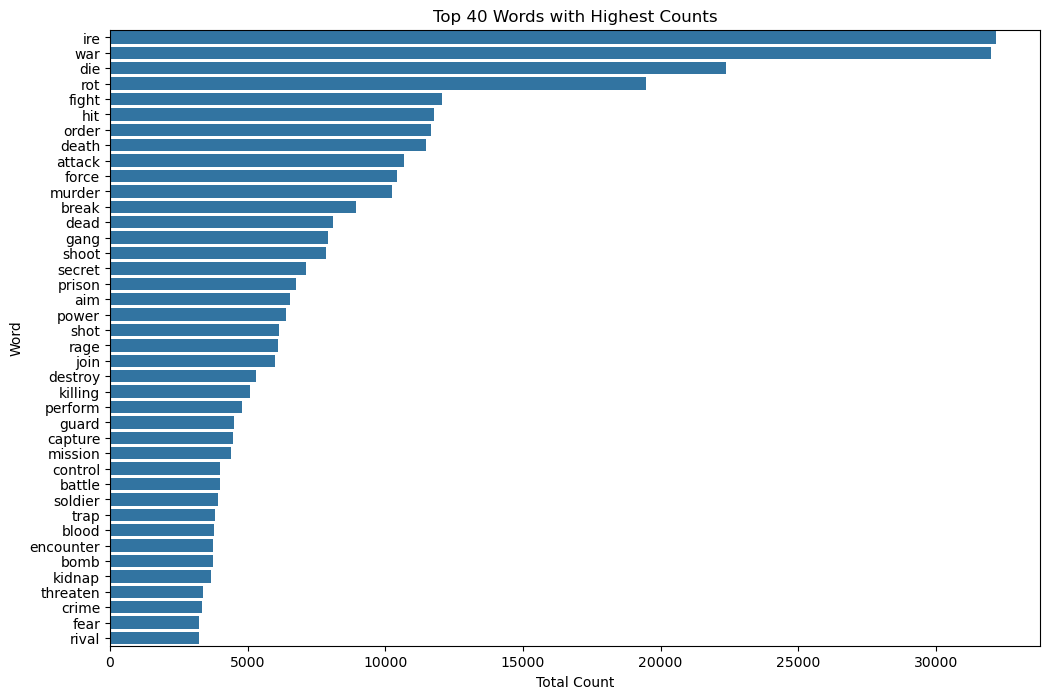

In [8]:
# Sum the word counts across all rows for each word
word_counts_per_column = findings.sum(axis=0)

# Sort the word counts in descending order and select the top N words
top_n_words = 40
top_words = word_counts_per_column.sort_values(ascending=False).head(top_n_words)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=top_words.values, y=top_words.index)
plt.title(f"Top {top_n_words} Words with Highest Counts")
plt.xlabel("Total Count")
plt.ylabel("Word")
plt.show()

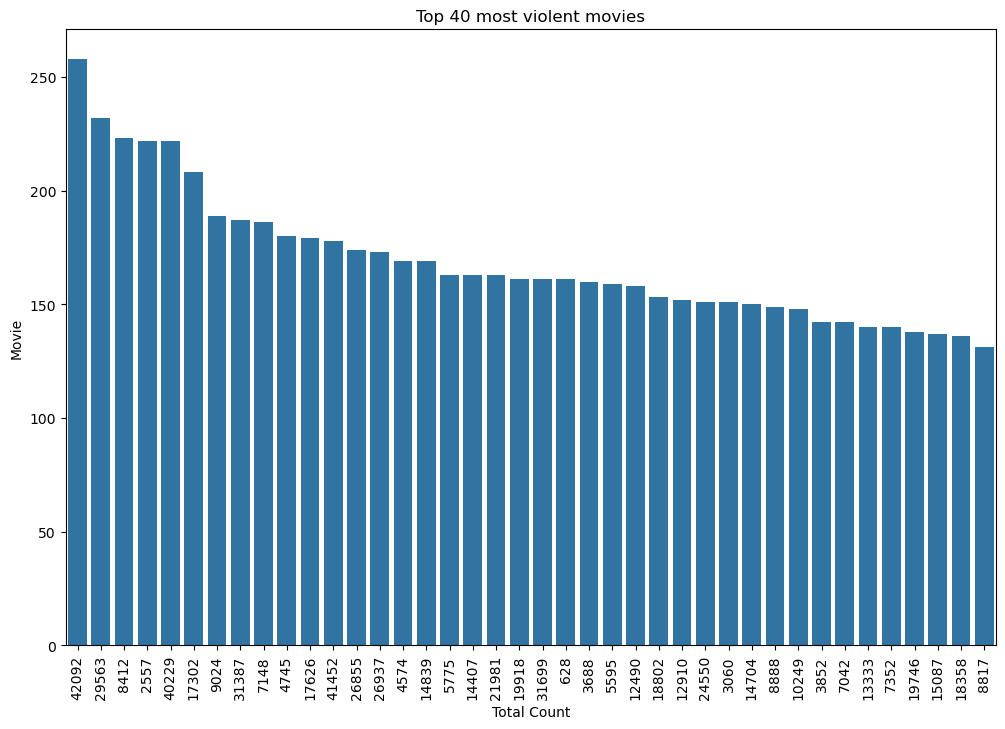

In [9]:
# Most violent movies

word_counts_per_movie = findings.sum(axis=1)

# Sort the word counts in descending order and select the top N movies (most violent)
top_n_movies = 40
top_movies = word_counts_per_movie.sort_values(ascending=False).head(top_n_words)

order = top_movies.index

# vu qu'il ne veut pas collaborer
top_movies = top_movies.reset_index()
top_movies.columns = ['movie id', 'violent words (all) count']

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x='movie id', y='violent words (all) count', data=top_movies, order=order)
plt.title(f"Top {top_n_words} most violent movies")
plt.xlabel("Total Count")
plt.ylabel("Movie")
plt.xticks(rotation=90)
plt.show()

## 1: Essayons de faire ça un peu propre

In [6]:
violent_words_list = [
    "acid", "aggressor", "agitator", "aim", "alert", "ambush", "ammunition", "anarchy", "anguish", 
    "annihilate", "apartheid", "arms", "arsenal", "artillery", "assassin", "assassinate", "assault", 
    "atrocity", "attack", "authority", "automatic", "barrage", "barricade", "battle", "battlefield", 
    "belligerent", "betrayal", "blast", "blindside", "blood", "bloody", "bomb", "bombardment", 
    "booby trap", "breach", "break", "brutal", "brutality", "brute", "bullet", "bully", "burn", 
    "cadaver", "camouflage", "campaign", "captive", "capture", "careen", "carnage", "casualties", 
    "cataclysm", "causes", "chaos", "charge", "charred", "checking", "clandestine", "clash", "coalition", 
    "collapse", "combat", "commandos", "concentration", "concussion", "conflagration", "conflict", 
    "confrontation", "conquer", "consequences", "consolidate", "conspiracy", "conspire", "control", 
    "coordinates", "corpse", "counterattack", "countermand", "crash", "crime", "crisis", "cross-hairs", 
    "culpability", "damage", "danger", "dangerous", "dash", "dead", "deadly", "death", "debacle", 
    "deception", "deliberate", "demolish", "demoralize", "despot", "destroy", "destruction", "detect", 
    "detection", "devastation", "device", "dictator", "dictatorship", "die", "disarmament", "disaster", 
    "disastrous", "discipline", "disease", "dispute", "disruption", "dissonance", "division", "domination", 
    "doom", "downfall", "drama", "dread", "encounter", "enemy", "enforce", "engagement", "epithet", 
    "escalate", "excess", "execute", "execution", "expectations", "explode", "exploitation", "explosion", 
    "explosive", "expunge", "extremism", "faction", "fanatic", "fatal", "fear", "fearful", "felon", 
    "ferment", "ferocious", "feud", "fierce", "fiery", "fight", "fighter", "force", "forceful", "forces", 
    "fray", "frenzy", "front lines", "fuel", "fugitive", "furtive", "gang", "gang up on", "gas", 
    "genocide", "germ warfare", "grave", "grenade", "grievous", "groans", "guard", "guerrillas", 
    "guided bombs", "guns", "gunship", "hammering", "harass", "harsh", "hatch", "hate", "hatred", 
    "hazard", "hiding", "hijack", "hijacker", "hit", "hit-and-run", "holocaust", "horror", "hostility", 
    "howitzer", "hurt", "ignite", "impact", "improvise", "incident", "incite", "incontrovertible", 
    "infanticide", "infiltrate", "inflame", "informant", "injuries", "inmate", "insurgent", "insurrection", 
    "intense", "intercept", "interdiction", "international", "interrogation", "intervene", "intimidate", 
    "invasion", "investigate", "investigations", "involvement", "ire", "jail", "jeer", "jets", "join", 
    "kamikaze", "keen", "kidnap", "killing", "knife", "knock-out", "land mines", "laser-activated", 
    "launch", "launcher", "loathsome", "machine guns", "maim", "malevolent", "malicious", "maraud", 
    "march", "massacre", "mayhem", "megalomania", "menace", "militancy", "militant", "militaristic", 
    "military", "militia", "mines", "missile", "mission", "mistreatment", "mob", "mobile", "mobilization", 
    "momentum", "mortars", "munitions", "murder", "muscle", "nationalist", "neutralize", "nightmare", 
    "nitrate", "notorious", "offensive", "officials", "onerous", "operation", "opposition", "order", 
    "out of control", "outbreak", "overrun", "overthrow", "pacify", "partisan", "patrol", "penetrate", 
    "perform", "persecute", "petrify", "photos", "pilot", "pistol", "planes", "plunder", "position", 
    "post-traumatic", "potent", "pound", "powder", "power", "powerful", "preemptive", "premeditate", 
    "prey", "prison", "prisoner", "proliferation", "provocation", "prowl", "pugnacious", "pulverize", 
    "pushing", "quail", "quarrel", "quell", "quiver", "radiation", "radical", "rage", "ravage", "ravish", 
    "rebel", "rebellion", "reconnaissance", "recovery", "recruit", "refugee", "regime", "regiment", 
    "reinforcements", "relentless", "reparation", "reprisal", "reputation", "resistance", "retaliation", 
    "retreat", "retribution", "revenge", "revolution", "ricochet", "rifle", "rift", "riot", "rival", 
    "rocket", "rot", "rounds", "rule", "ruthless", "sabotage", "sacrifice", "salvage", "sanction", 
    "savage", "scare", "score", "scramble", "secrecy", "secret", "sedition", "seize", "seizure", 
    "sensor", "setback", "shelling", "shells", "shock", "shoot", "shot", "showdown", "siege", "skirmish", 
    "slaughter", "smash", "smuggle", "soldier", "special-ops", "specialized", "spy", "spy satellite", 
    "squad", "stalk", "stash", "stealth", "storm", "straggler", "strangle", "strategic", "strategist", 
    "strategy", "strength", "strife", "strike", "strip", "stronghold", "struggle", "subversive", 
    "suffering", "superstition", "supplies", "support", "suppression", "surprise", "surrender", 
    "survival", "survivor", "suspect", "tactics", "tank", "target", "tension", "terror", "terrorism", 
    "terrorist", "terrorize", "threaten", "thug", "thwart", "topple", "torch", "tornado", "torpedo", 
    "tourniquet", "tragic", "training", "trample", "trap", "trauma", "treachery", "trench", "trigger", 
    "triumph", "tsunami", "turbulent", "unbelievable", "unconventional", "unleash", "unruly", 
    "uprising", "urgency", "vagrant", "vanguard", "vanish", "vehicle", "vehicular", "vendetta", 
    "venomous", "vicious", "victory", "vile", "vilify", "violation", "violence", "virulence", "vital", 
    "vitriol", "vociferous", "void", "vow", "vulnerability", "wage", "war", "warheads", "warplane", 
    "warrant", "warrior", "watchdog", "watchful", "weapon", "weather", "well-trained", "wisdom", 
    "worldwide", "wound", "wreckage", "x-ray", "yearn", "yelling", "zeal", "zealot", "zigzag", "zone"
]


In [7]:
#for word in violent_words_list:
#    CMU_plot_summary[f'{word}'] = CMU_plot_summary['plot_summary'].apply(lambda x: x.lower().count(word))

# add the title column for later
CMU_plot_summary = CMU_plot_summary.merge(CMU_movie_metadata[['wikipedia_movie_ID', 'movie_name']], on='wikipedia_movie_ID', how='left')
CMU_plot_summary = CMU_plot_summary.merge(CMU_movie_metadata[['wikipedia_movie_ID', 'movie_genres']], on='wikipedia_movie_ID', how='left')

word_counts = {word: CMU_plot_summary['plot_summary'].apply(lambda x: x.lower().count(word)/len(x.split())) for word in violent_words_list}
word_counts_df = pd.DataFrame(word_counts)
CMU_plot_summary = pd.concat([CMU_plot_summary, word_counts_df], axis=1)

display(CMU_plot_summary)

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,acid,aggressor,agitator,aim,alert,ambush,...,worldwide,wound,wreckage,x-ray,yearn,yelling,zeal,zealot,zigzag,zone
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",0.0,0.0,0.0,0.002571,0.0,0.001285,...,0.0,0.002571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...",0.0,0.0,0.0,0.006048,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{""/m/0bj8m2"": ""Children's""}",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,"{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{""/m/07s9rl0"": ""Drama""}",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
word_columns = CMU_plot_summary.columns.difference(['wikipedia_movie_ID', 'plot_summary', 'movie_name', 'total_violent_words', 'movie_genres'])

# Sum across columns (per movie) to get the total appearances of all words in each summary
CMU_plot_summary['total_violent_words'] = CMU_plot_summary[word_columns].sum(axis=1)

#  Sum across rows (per word) to get the total appearances of each word across all summaries
first_conclusions = pd.DataFrame()
first_conclusions['total_movies_appearances'] = CMU_plot_summary[word_columns].sum(axis=0)

In [13]:
display(CMU_plot_summary)
display(first_conclusions)

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,acid,aggressor,agitator,aim,alert,ambush,...,wound,wreckage,x-ray,yearn,yelling,zeal,zealot,zigzag,zone,total_violent_words
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",0.0,0.0,0.0,0.002571,0.0,0.001285,...,0.002571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061697
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...",0.0,0.0,0.0,0.006048,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064516
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031802
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{""/m/0bj8m2"": ""Children's""}",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051527
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,"{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music...",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012500
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{""/m/07s9rl0"": ""Drama""}",0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017391


,total_movies_appearances
acid,0.667865
aggressor,0.040393
agitator,0.047649
aim,18.575383
alert,1.407238
...,...
yelling,0.286552
zeal,1.020969
zealot,0.073353
zigzag,0.020643


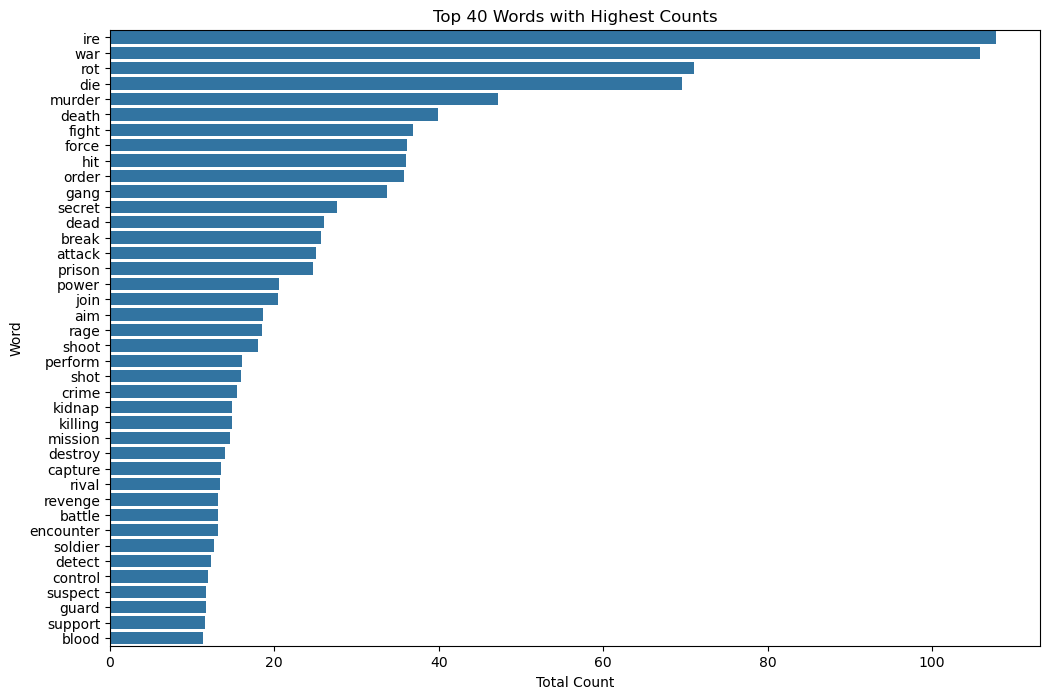

In [14]:
top_n_words = 40
top_words = first_conclusions['total_movies_appearances'].sort_values(ascending=False).head(top_n_words)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=top_words.values, y=top_words.index)
plt.title(f"Top {top_n_words} Words with Highest Counts")
plt.xlabel("Total Count")
plt.ylabel("Word")
plt.show()

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,acid,aggressor,agitator,aim,alert,ambush,...,wound,wreckage,x-ray,yearn,yelling,zeal,zealot,zigzag,zone,total_violent_words
12813,34188375,Former mercenary kidnapping expert hired by a ...,Six Bullets,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000
6334,23923922,"Two men join forces to build a cattle empire, ...",American Empire,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352941
10802,25011263,"During the Korean War, a group of American sol...",The Hook,"{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343750
869,14399659,A top secret American forces strategic bomber ...,Midnight Eagle,"{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Actio...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
6140,31304298,"During the First World War, Russian forces att...",13 Men and a Gun,"{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312500
14812,15502188,"Liberty Horton, an American heiress, is kidnap...",Liberty,"{""/m/06ppq"": ""Silent film"", ""/m/0hfjk"": ""Weste...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294118
25762,33473147,Three Korean soldiers are faced with a dark pa...,The Showdown,"{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277778
28305,28749199,A Heiress's life threatened by stalker after h...,Adayalam,"{""/m/02n4kr"": ""Mystery""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727
12333,12494928,The movie about a female detective who is forc...,Stripped to Kill,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727
30191,22799564,The film follows a hot summer day in the life ...,Ordinary People,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270270


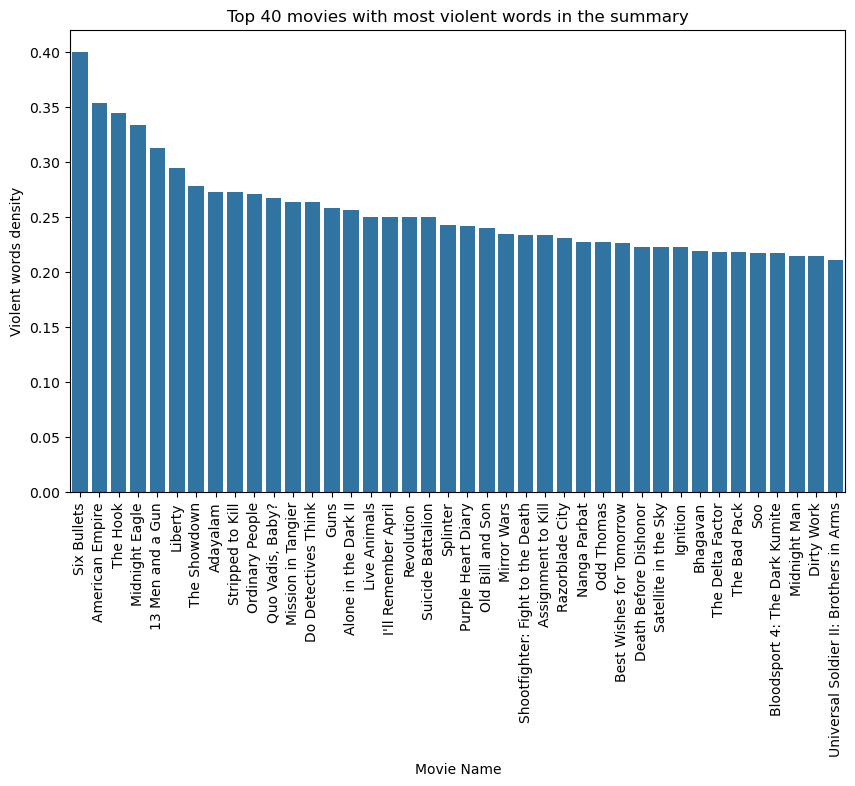

In [19]:

CMU_plot_summary_sorted_by_violent_words = CMU_plot_summary.sort_values(by='total_violent_words', ascending=False)

top_movies = CMU_plot_summary_sorted_by_violent_words.head(40)

display(top_movies)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies['movie_name'], y=top_movies['total_violent_words'], order=top_movies.movie_name) # this order works!!
plt.xlabel("Movie Name")
plt.ylabel("Violent words density")
plt.title("Top 40 movies with most violent words in the summary")
plt.xticks(rotation=90)
plt.show()

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,acid,aggressor,agitator,aim,alert,ambush,...,wound,wreckage,x-ray,yearn,yelling,zeal,zealot,zigzag,zone,total_violent_words
12813,34188375,Former mercenary kidnapping expert hired by a ...,Six Bullets,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000
6334,23923922,"Two men join forces to build a cattle empire, ...",American Empire,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352941
10802,25011263,"During the Korean War, a group of American sol...",The Hook,"{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343750
869,14399659,A top secret American forces strategic bomber ...,Midnight Eagle,"{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Actio...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
6140,31304298,"During the First World War, Russian forces att...",13 Men and a Gun,"{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40094,33486340,Dad Made Dirty Movies chronicles Stephen C. Ap...,"\\""Dad Made Dirty Movies\\""","{""/m/0jtdp"": ""Documentary""}",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116279
6787,31748184,This knockabout English comedy is a spoof on t...,The Vampires of Bloody Island,"{""/m/05p553"": ""Comedy film"", ""/m/03npn"": ""Horr...",0.0,0.0,0.0,0.007752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116279
2385,105394,"The film, a tongue-in-cheek satire of typical ...",Girlfriend From Hell,"{""/m/01hmnh"": ""Fantasy"", ""/m/03npn"": ""Horror"",...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116279
10052,7185465,Guns and Talks follows a team of four skilled ...,Guns & Talks,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/03q4nz"": ""Wo...",0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116279


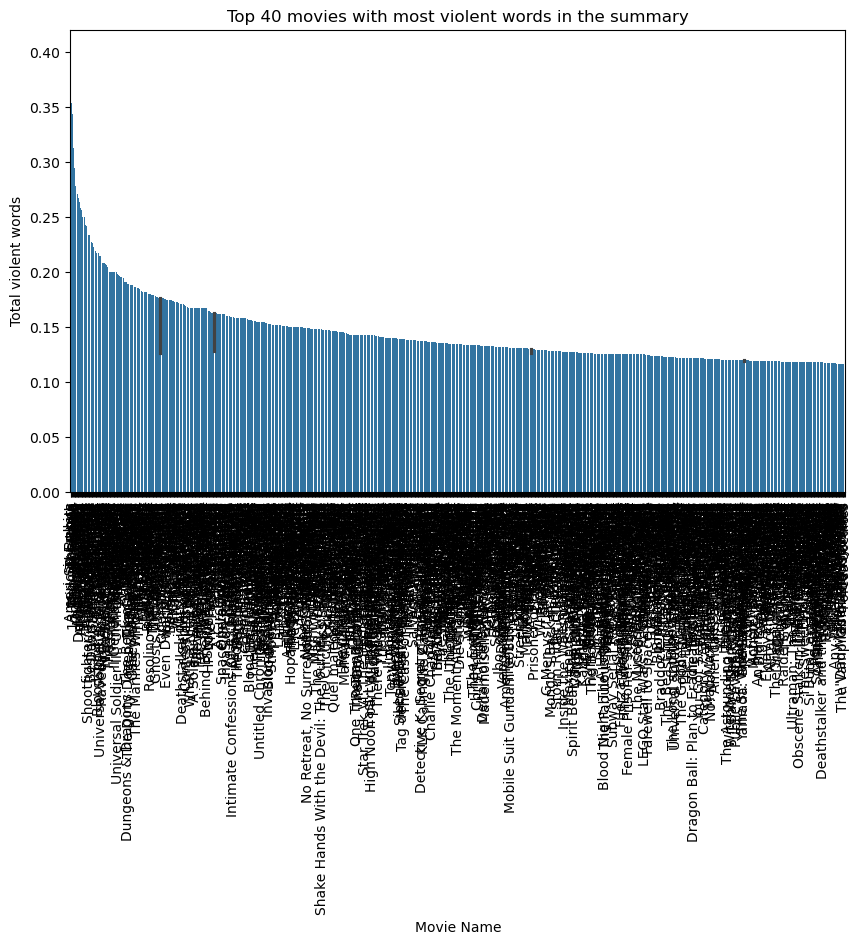

In [17]:

CMU_plot_summary_sorted_by_violent_words = CMU_plot_summary.sort_values(by='total_violent_words', ascending=False)

top_movies = CMU_plot_summary_sorted_by_violent_words.head(1000)

display(top_movies)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies['movie_name'], y=top_movies['total_violent_words'], order=top_movies.movie_name) # this order works!!
plt.xlabel("Movie Name")
plt.ylabel("Total violent words")
plt.title("Top 40 movies with most violent words in the summary")
plt.xticks(rotation=90)
plt.show()

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,acid,aggressor,agitator,aim,alert,ambush,...,wound,wreckage,x-ray,yearn,yelling,zeal,zealot,zigzag,zone,total_violent_words
9416,28164962,<ref namehttp://www2u.biglobe.ne.jp/~p-g/data/...,Three Naked Sisters: Lewdness,"{""/m/0gw5n2f"": ""Japanese Movies""}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3902,34985175,This tale depicts the relationship between the...,HM HM,"{""/m/02hmvc"": ""Short Film"", ""/m/0hcr"": ""Animat...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18552,28178332,A head waiter in a country hotel works various...,Small Hotel,"{""/m/05p553"": ""Comedy film""}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27026,1802864,"The film is centered on Spencer , who moves to...",According to Spencer,"{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39042,33175534,"Set in the year 1980, the Enterprise explores ...",Steam Trek: The Moving Picture,"{""/m/02hmvc"": ""Short Film"", ""/m/068twy"": ""Fan ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14705,36353254,The movie revolves around four young men who a...,The Reunion,"{""/m/05p553"": ""Comedy film""}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7211,22781881,The film follows the formative years of Vladi...,A Mother's Heart,{},0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36431,4837697,Koi Tujh Sa Kahan revolves around a loving hus...,Koi Tujh Sa Kahan,"{""/m/07s9rl0"": ""Drama""}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7221,34952810,Fatma is old and lame. She has worked all her ...,Fatma,"{""/m/02hmvc"": ""Short Film""}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


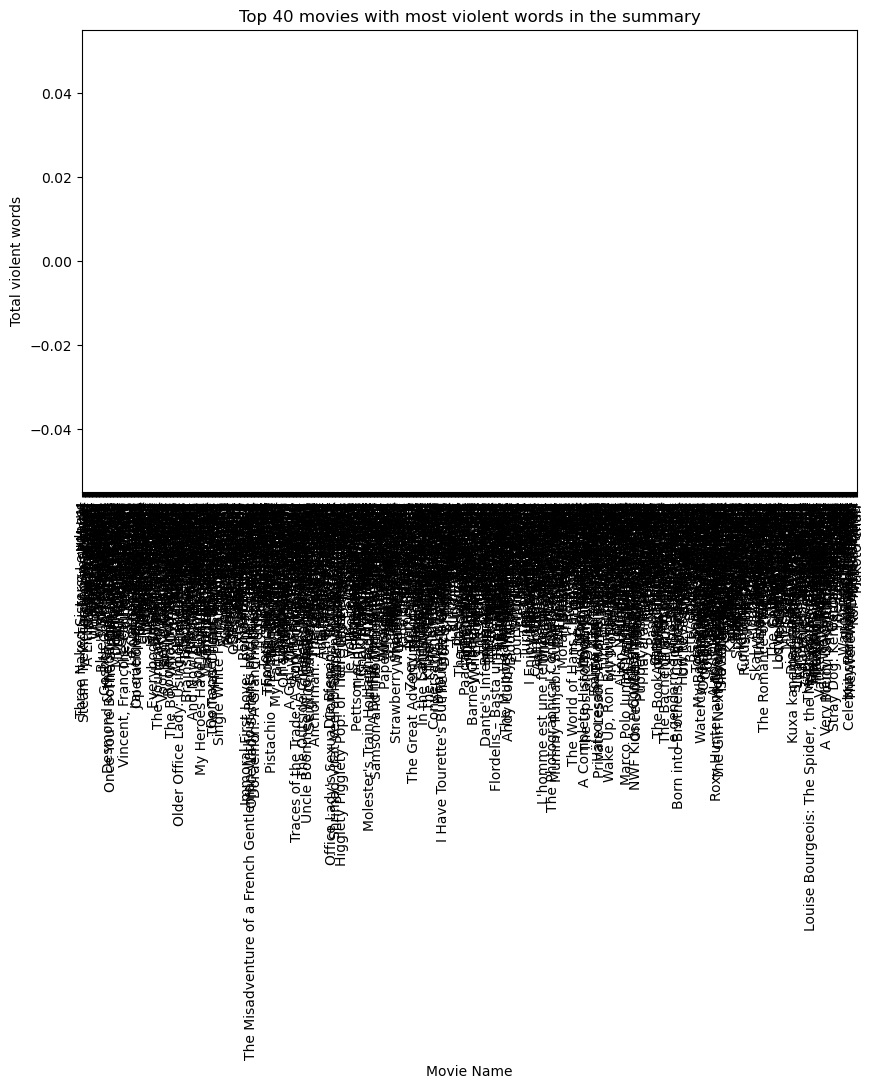

In [18]:
CMU_plot_summary_sorted_by_violent_words = CMU_plot_summary.sort_values(by='total_violent_words', ascending=True)

top_movies = CMU_plot_summary_sorted_by_violent_words.head(1000)

display(top_movies)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies['movie_name'], y=top_movies['total_violent_words'], order=top_movies.movie_name) # this order works!!
plt.xlabel("Movie Name")
plt.ylabel("Total violent words")
plt.title("Top 40 movies with most violent words in the summary")
plt.xticks(rotation=90)
plt.show()

## 2: New investigation: let's look at psychological violence

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Path to the data folders
raw_data_folder = '../data/RAW/'
clean_data_folder = '../data/CLEAN/'

In [72]:
# Load the movie metadata
CMU_movie_metadata = pd.read_csv(raw_data_folder+'CMU_Movies_Dataset/movie.metadata.tsv', delimiter='\t', header=None)
CMU_movie_metadata.columns = ['wikipedia_movie_ID', 'freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
#display(CMU_movie_metadata.head(10))

# Load the plot summaries
CMU_plot_summary = pd.read_csv(raw_data_folder+'CMU_Movies_Dataset/plot_summaries.txt', sep='\t', header=None)
CMU_plot_summary.columns = ['wikipedia_movie_ID', 'plot_summary']

In [73]:
# Add the movie titles and the genres
CMU_plot_summary = CMU_plot_summary.merge(CMU_movie_metadata[['wikipedia_movie_ID', 'movie_name', 'movie_genres']], on='wikipedia_movie_ID', how='left')

# Lower case the plot_summaries
CMU_plot_summary['plot_summary'] = CMU_plot_summary['plot_summary'].str.lower()

In [78]:
# First, to avoid errors, we remove the NAN, so that we can then apply extract_genres to all CMU_movies_sprted_psycho
CMU_plot_summary['movie_genres'] = CMU_plot_summary['movie_genres'].fillna('')

def extract_genres(text):
    # Find all matches for genre names using a regex pattern that matches quoted text after colon
    return ', '.join(re.findall(r'": "([^"]+)"', text))

# Apply to the whole 'movie_genres' column
CMU_plot_summary['movie_genres'] = CMU_plot_summary['movie_genres'].apply(extract_genres)

display(CMU_plot_summary)

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,total_psycho_vio_words,n_words_summary,total_psycho_vio_words_density
0,23890098,"shlykov, a hard-working taxi driver and lyosha...",Taxi Blues,"Drama, World cinema",0,25,0.000000
1,31186339,the nation of panem consists of a wealthy capi...,The Hunger Games,"Action/Adventure, Science Fiction, Action, Drama",5,778,0.006427
2,20663735,poovalli induchoodan is sentenced for six yea...,Narasimham,"Musical, Action, Drama, Bollywood",0,496,0.000000
3,2231378,"the lemon drop kid , a new york city swindler,...",The Lemon Drop Kid,"Screwball comedy, Comedy",7,849,0.008245
4,595909,seventh-day adventist church pastor michael ch...,A Cry in the Dark,"Crime Fiction, Drama, Docudrama, World cinema,...",3,397,0.007557
...,...,...,...,...,...,...,...
42298,34808485,"the story is about reema , a young muslim scho...",Oomakkuyil Padumbol,Children's,1,40,0.025000
42299,1096473,"in 1928 hollywood, director leo andreyev look...",The Last Command,"Silent film, Indie, Black-and-white, Period pi...",1,524,0.001908
42300,35102018,american luthier focuses on randy parsons’ tra...,Randy Parsons: American Luthier,"Short Film, Music, Biographical film, Documentary",0,160,0.000000
42301,8628195,"abdur rehman khan , a middle-aged dry fruit se...",Kabuliwala,Drama,2,230,0.008696


In [79]:
psycho_violence_list = [
    "abandon",
    "abandoned",
    "abandoning",
    "abandonment",
    "abuse",
    "abused",
    "abusing",
    "abusive",
    "agitate",
    "agitated",
    "agitating",
    "agony",
    "alienate",
    "alienated",
    "alienating",
    "amnesia",
    "anger",
    "angry",
    "anguish",
    "animalistic",
    "antagonise",
    "antagonize",
    "attack",
    "attacked",
    "attacking",
    "anxious",
    "avoid",
    "avoided",
    "avoiding",
    "backhanded",
    "belittle",
    "belittled",
    "belittling",
    "betray",
    "betrayal",
    "betrayed",
    "betraying",
    "blackmail",
    "blackmailed",
    "blackmailing",
    "blame",
    "blamed",
    "blame-shifting",
    "blaming",
    "brainwash",
    "brainwashed",
    "brainwashing",
    "break",
    "breaking",
    "broken",
    "bully",
    "bullied",
    "bullying",
    "catastrophise",
    "catastrophize",
    "catastrophising",
    "catastrophizing",
    "chaos",
    "condescending",
    "condescendent",
    "condition",
    "conditional",
    "control",
    "controlled",
    "controlling",
    "criticism",
    "criticise",
    "criticize",
    "criticised",
    "criticized",
    "criticising",
    "criticizing",
    "cruel",
    "cruelty",
    "damaging",
    "deceive",
    "deceit",
    "deceptive",
    "defame",
    "demean",
    "demeaned",
    "demeaning",
    "delude",
    "deluded",
    "deluding",
    "delusion",
    "delusional",
    "demoralize",
    "deny",
    "denial",
    "denied",
    "denying",
    "dependency",
    "depressed",
    "depression",
    "despair",
    "destructive",
    "discredit",
    "discredited",
    "discrediting",
    "dishonest",
    "dismiss",
    "dismissal",
    "dismissed",
    "dismissing",
    "dismissive",
    "disillusioned",
    "disorder",
    "disregard",
    "distress",
    "dominate",
    "dominated",
    "dominating",
    "domination",
    "downgrade",
    "downgraded", 
    "downgrading",
    "dread",
    "embarrass",
    "embarrassed",
    "embarrassing",
    "embarrassment",
    "entitle",
    "entitled",
    "entitlement",
    "exclude",
    "excluded",
    "excluding",
    "exclusion",
    "exploit",
    "exploited",
    "exploitation",
    "exploitative",
    "extortion",
    "fabricated",
    "fear",
    "fearing",
    "fearful",
    "fear-monger",
    "fear-mongered",
    "fear-mongering",
    "frighten",
    "frightened",
    "frightening",
    "gaslight",
    "gaslighted",
    "gaslighting",
    "gaslit",
    "guilt-trip",
    "guilt-tripped",
    "guilt-tripping",
    "guilty",
    "hallucinate",
    "hallucinated",
    "hallucinating",
    "hallucination",
    "harass",
    "harassed",
    "harassing",
    "harassment",
    "helplessness",
    "hoover",
    "hoovered",
    "hoovering",
    "hopelessness",
    "hostile",
    "hostility",
    "humiliate",
    "humiliated",
    "humiliating",
    "humiliation",
    "hurt",
    "hurting",
    "hypercriticise",
    "hypercriticize",
    "hypercriticised",
    "hypercriticized",
    "hypercriticising",
    "hypercriticizing",
    "ignore",
    "ignored",
    "ignoring",
    "illicit",
    "ill-treated",
    "ill-treatment",
    "illude",
    "illusion",
    "implode",
    "implosion",
    "inferior",
    "inferiority",
    "insane",
    "insanity",
    "insult",
    "insulted",
    "insulting",
    "intimidate",
    "intimidated",
    "intimidating",
    "intimidation",
    "invalidate",
    "invalidated",
    "invalidating",
    "invalidation",
    "isolate",
    "isolated",
    "isolating",
    "isolation",
    "jealous",
    "jealousy",
    "judgmental",
    "lie",
    "lied",
    "lying",
    "love-bomb",
    "love-bombed",
    "love-bombing",
    "mad",
    "madden",
    "maddened",
    "maddening",
    "madness",
    "manipulate",
    "manipulated",
    "manipulating",
    "manipulation",
    "manipulative",
    "mentally",
    "minimise",
    "minimize",
    "minimised",
    "minimized",
    "minimising",
    "minimizing",
    "mock",
    "mocked",
    "mockery",
    "mocking",
    "name-call",
    "name-called",
    "name-calling",
    "narcissism",
    "narcissist",
    "narcissistic",
    "neglect",
    "neglected",
    "neglecting",
    "normalise",
    "normalize",
    "normalised",
    "normalized",
    "normalising",
    "normalizing",
    "numb",
    "obsess", 
    "obsession",
    "obsessive",
    "oppressive",
    "oppression",
    "overprotect",
    "overprotected",
    "overprotecting",
    "overprotective",
    "outburst",
    "pain",
    "painfull",
    "paralised",
    "paralyzed",
    "paranoia",
    "passive-agressive",
    "patronise",
    "patronize",
    "patronised",
    "patronized",
    "patronising",
    "patronizing",
    "perverse",
    "possess",
    "possessed",
    "possessing",
    "possessive",
    "possessiveness",
    "power",
    "pretend",
    "project",
    "projected",
    "projecting",
    "projection",
    "psycho",
    "psychological",
    "psychopath",
    "psychology",
    "rage",
    "reject",
    "rejected",
    "rejecting",
    "rejection",
    "repress",
    "repressed",
    "repressing",
    "repression",
    "ridicule",
    "ridiculed",
    "ridiculing",
    "sabotage",
    "sabotaged",
    "sabotaging",
    "sad",
    "sadden",
    "saddened",
    "saddening",
    "sadness",
    "sarcasm",
    "scapegoat",
    "scapegoated",
    "scapegoating",
    "scared",
    "scaring",
    "scorn",
    "scorned",
    "scorning",
    "self-centered",
    "shame",
    "shamed",
    "shaming",
    "shatter",
    "shout",
    "shouted",
    "shouting",
    "sleep-deprived",
    "slander",
    "slandered",
    "slandering",
    "smear",
    "smeared",
    "smearing",
    "smother",
    "smothered",
    "smothering",
    "sneer",
    "sneered",
    "sneering",
    "stonewall",
    "stonewalled",
    "stonewalling",
    "stalk",
    "stalked",
    "stalking",
    "suicide",
    "suppress",
    "suppressed",
    "suppressing",
    "tactic",
    "threat",
    "threaten",
    "threatened",
    "threatening",
    "threats",
    "torment",
    "tormented",
    "tormenting",
    "trauma",
    "traumatise",
    "traumatize",
    "traumatised",
    "traumatized",
    "traumatising",
    "traumatizing",
    "triangulate",
    "triangulated",
    "triangulating",
    "two-faced",
    "ultimatum",
    "ultimatums",
    "unappreciated",
    "undermine",
    "undermined",
    "undermining",
    "undervalued",
    "undervaluation",
    "unhealthy",
    "unpredictable",
    "unstable",
    "untrustworthiness",
    "untrustworthy",
    "unworthy",
    "vengeful",
    "verbal abuse",
    "victim-blame",
    "victim-blamed",
    "victim-blaming",
    "vindictive",
    "vulnerable",
    "weaponise",
    "weaponize",
    "weaponised",
    "weaponized",
    "weaponising",
    "weaponizing",
    "withhold",
    "withheld",
    "withholding",
    "word salad",
    "yell",
    "yelled",
    "yelling"
]

#print(len(psycho_violence_list))

In [80]:
def find_all_occurences(type_violence_list, CMU_plot_summary):
    # Reshape the list
    pattern_psycho = r'\b(?:' + '|'.join(type_violence_list) + r')\b'
    # Calculate the appearances
    CMU_plot_summary['total_psycho_vio_words'] = CMU_plot_summary['plot_summary'].str.findall(pattern_psycho).str.len()

find_all_occurences(psycho_violence_list, CMU_plot_summary)

# Count the number of words in the summary
CMU_plot_summary['n_words_summary'] = CMU_plot_summary['plot_summary'].str.split().str.len()

# Calculate the "violent words density" by dividing the violent words count by the number of words in the plot summary for each movie
CMU_plot_summary['total_psycho_vio_words_density'] = CMU_plot_summary['total_psycho_vio_words'] / CMU_plot_summary['n_words_summary']

In [84]:
# Sort the movies according to their violent words
CMU_movies_sorted_psycho_words = CMU_plot_summary.sort_values(by='total_psycho_vio_words', ascending=False)
display(CMU_movies_sorted_psycho_words)

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,total_psycho_vio_words,n_words_summary,total_psycho_vio_words_density
15583,30201005,the film opens with j. edgar hoover in his of...,J. Edgar,"LGBT, Biographical film, Drama, Political drama",46,963,0.047767
17302,10619079,episode 1: a new life formvajra>vajra is a san...,Genocyber,Animation,44,3793,0.011600
3060,21768047,{{plot}} fuyuki hinata and the keroro platoon ...,Keroro Gunso the Super Movie 3: Keroro vs. Ker...,Japanese Movies,30,3144,0.009542
13858,21766755,the movie opens with a horse grazing in a smal...,The Pack,"Natural horror films, Horror",30,1766,0.016988
2557,11103867,"the story begins with teru aoki , the main pr...",Dragon Head,"Science Fiction, Horror, World cinema, Anime, ...",28,3382,0.008279
...,...,...,...,...,...,...,...
28667,31504552,"vampire aliens dr. kozmar , dr. zarma and cor...",Evils of the Night,"Alien Film, Science Fiction, Horror, Slasher, ...",0,88,0.000000
28666,4622101,the plot revolves around a professional wrestl...,Ika resuraa,"Japanese Movies, Comedy",0,36,0.000000
15643,36190244,the film is set in a los angeles high school. ...,Mac & Devin Go to High School,Comedy film,0,116,0.000000
28664,27637773,no way to heaven begins on a remote island in ...,No Way To Heaven,Documentary,0,68,0.000000


In [87]:
# Sort the movies according to their violent words density in the plot summary
CMU_movies_sorted_psycho_density = CMU_plot_summary.sort_values(by='total_psycho_vio_words_density', ascending=False)
display(CMU_movies_sorted_psycho_density)

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,total_psycho_vio_words,n_words_summary,total_psycho_vio_words_density
10427,9612611,"mysterious pilot, the eagle, attempts to sabot...",The Shadow of the Eagle,"Crime Fiction, Adventure, Detective, Black-and...",2,16,0.125000
28359,28807164,the daughters of a domineering mother aspire t...,Deadly Advice,"Drama, Comedy",2,17,0.117647
19549,34596327,a journalist who covered the vietnam war becom...,The Beast to Die,"Crime Fiction, Action, Drama",2,19,0.105263
20177,33244835,"broken hearted, jill is blindsided by her boyf...",Wishful Thinking,Short Film,1,11,0.090909
39099,24344249,an isolated and lonely farmer in rural mississ...,Tomorrow,"Crime Fiction, Indie, Drama, Romantic drama, R...",2,23,0.086957
...,...,...,...,...,...,...,...
7611,19922240,two condemned soldiers and their overseeing w...,Salt in the Wound,"Drama, War film",0,82,0.000000
17295,7725336,"zoe adler , is a shy, eccentric and misunderst...",Cherish,"Thriller, Crime Fiction, Indie, Comedy-drama, ...",0,136,0.000000
27740,936787,danny and bernie are two single men who live i...,About Last Night,"Romantic comedy, Comedy-drama, Drama, Comedy, ...",0,83,0.000000
13231,9411771,"based on an original play by bruce walker, the...",Cosh Boy,"Crime Fiction, Drama",0,346,0.000000


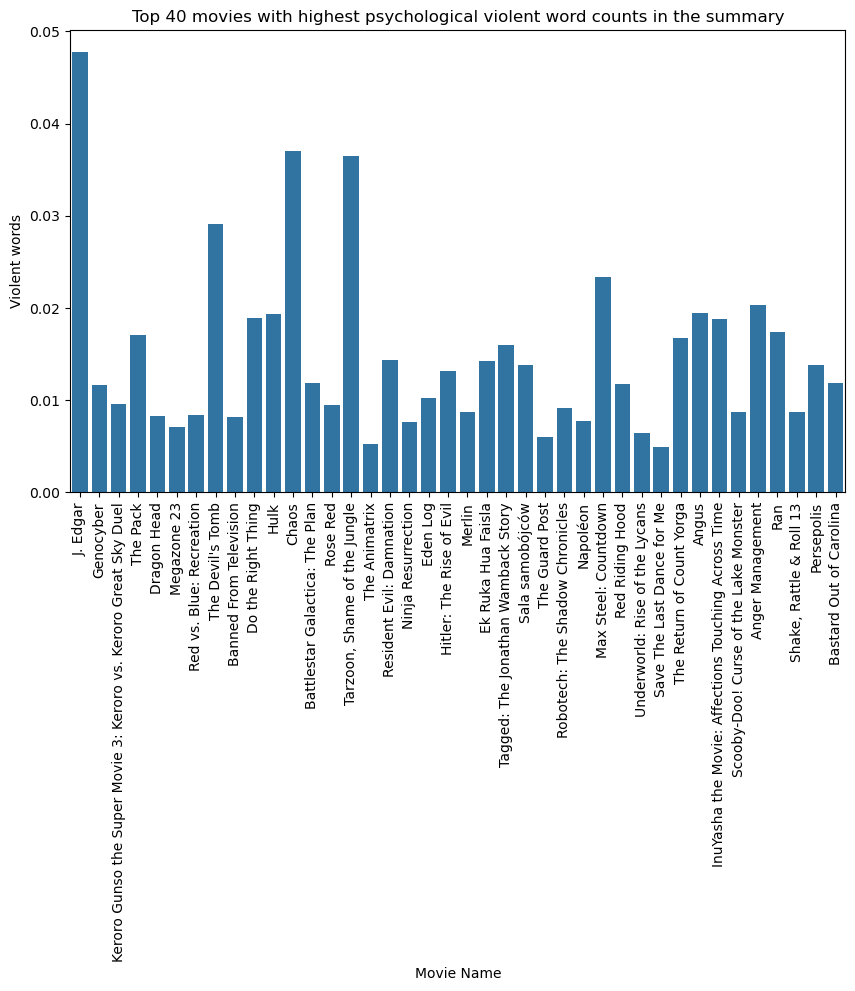

In [91]:
# Plot the results

top_movies_by_words = CMU_movies_sorted_psycho_words.head(40)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies_by_words['movie_name'], y=top_movies_by_words['total_psycho_vio_words_density'])
plt.xlabel("Movie Name")
plt.ylabel("Violent words")
plt.title("Top 40 movies with highest psychological violent word counts in the summary")
plt.xticks(rotation=90)
plt.show()

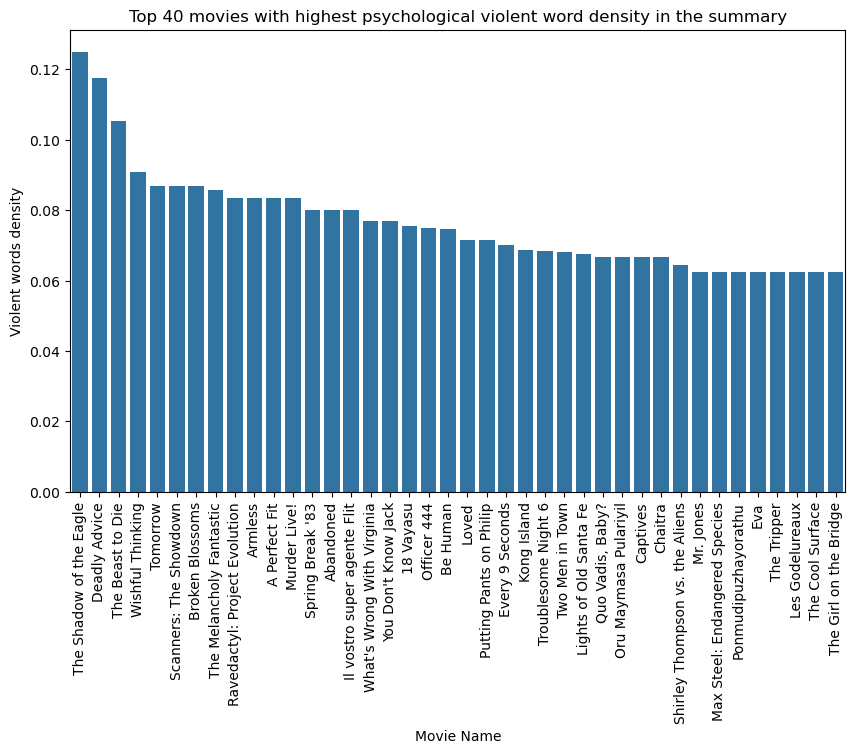

In [89]:
top_movies_density = CMU_movies_sorted_psycho_density.head(40)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies_density['movie_name'], y=top_movies_density['total_psycho_vio_words_density'])
plt.xlabel("Movie Name")
plt.ylabel("Violent words density")
plt.title("Top 40 movies with highest psychological violent word density in the summary")
plt.xticks(rotation=90)
plt.show()

In [85]:
top_movies['movie_genres'].value_counts()


movie_genres
Drama                                                                                       4
Short Film                                                                                  2
Crime Fiction, Adventure, Detective, Black-and-white, Action/Adventure, Western, Action     1
Thriller, Drama                                                                             1
Silent film, Indie, Black-and-white, Short Film, Comedy, Slapstick                          1
Science Fiction, Horror                                                                     1
Horror, Chinese Movies                                                                      1
Thriller, Crime Fiction, World cinema, Crime Drama, Drama, Crime Thriller                   1
Action/Adventure, Western, Action, Musical                                                  1
Thriller, Crime Fiction, Indie, Mystery, Drama, Suspense, Romantic drama, Romance Film      1
Short Film, Family Film, Comedy, Animation     

### A little bit of random investigation down here (to be deleted)

In [40]:
print(CMU_movies_sorted_psycho.loc[CMU_movies_sorted_psycho['movie_name'] == 'Perverse Hallucination'])

Empty DataFrame
Columns: [wikipedia_movie_ID, plot_summary, movie_name, movie_genres, total_psycho_vio_words, n_words_summary, total_psycho_vio_words_density]
Index: []


In [41]:
display(CMU_movies_sorted_psycho.loc[CMU_movies_sorted_psycho['movie_genres'] == 'Psychological thriller'])

,wikipedia_movie_ID,plot_summary,movie_name,movie_genres,total_psycho_vio_words,n_words_summary,total_psycho_vio_words_density
30628,33446745,kingsley's character is a man pushed to his li...,A Common Man,Psychological thriller,0,87,0.0
41842,36359227,18 vayasu is all about a mentally unstable you...,18 Vayasu,Psychological thriller,0,53,0.0
40681,31934171,"a ruthless rubber baron, mathukutty, disregard...",Irakal,Psychological thriller,0,42,0.0
7802,29425225,"at 1946, during the nuremberg trials, the czec...","I, Justice",Psychological thriller,0,159,0.0
266,16898363,daniel and laura are a young couple vacation...,Fata Morgana,Psychological thriller,0,332,0.0
3098,33832193,"a child suspected of having killed his father,...",Il diavolo nel cervello,Psychological thriller,0,27,0.0
16697,32126486,"a playwright, martine suffers from paranoia a...",The Letter,Psychological thriller,0,53,0.0
20345,29195939,"the film opens with the a woman, niamh , dragg...",The Lark,Psychological thriller,0,1021,0.0
20159,28104226,"samar , an eight-year-old motherless boy lives...",Nadunissi Naaygal,Psychological thriller,0,580,0.0
15082,19092476,"ziegenthals , a failed student, makes ends me...",One or the Other of Us,Psychological thriller,0,248,0.0


In [12]:
pattern_psycho = r'(?<!\w)(?:' + '|'.join(psycho_violence_list) + r')(?!\w)'


print(pattern_psycho)
display(CMU_plot_summary.loc[CMU_plot_summary['movie_name'] == '18 Vayasu']['plot_summary'])
display(CMU_plot_summary['plot_summary'][41842])


(?<!\w)(?:abandon|abandoned|abandoning|abuse|abused|abusing|abusive|agony|alienate|alienated|alienating|amnesia|animalistic|anxious|avoid|avoided|avoiding|belittle|belittled|belittling|blackmail|blackmailed|blackmailing|blame|blamed|blaming|brainwash|brainwashed|brainwashing|break|breaking|broken|bully|bullied|bullying|chaos|condition|conditional|control|controlled|controlling|criticism|criticize|criticized|criticizing|damaging|delude|deluded|deluding|delusion|delusional|deny|denial|denied|denying|destructive|dismiss|dismissal|dismissed|dismissing|disorder|embarrass|embarrassed|embarrassing|embarrassment|entitle|entitled|entitlement|exclude|excluded|excluding|exploitation|exploit|exploited|exploiting|extortion|fear|fearing|frighten|frightened|frightening|gaslight|gaslighted|gaslighting|guilty|hallucinate|hallucinated|hallucinating|hallucination|harass|harassed|harassing|harassment|hoover|hoovered|hoovering|humiliate|humiliated|humiliating|humiliation|hurt|hurting|hypercriticize|hypercr

41842    18 vayasu is all about a mentally unstable you...
Name: plot_summary, dtype: object

'18 vayasu is all about a mentally unstable youngster, who falls in love. be it happiness or anger, he has a unique way of expressing it. whenever he is depressed, he takes on the behaviour of an animal that he sights first.it released on august 24, 2012 and received negative reviews.[1][2] [3]18-vayasu-movie-trailer.{{cite web}}'

In [13]:
count = 0
for word in psycho_violence_list:
    count += CMU_plot_summary['plot_summary'][41842].count(word)

display(count)
display(CMU_plot_summary['plot_summary'][41842].count(pattern_psycho))

2

0

In [97]:
display(CMU_plot_summary.loc[CMU_plot_summary['movie_name'] == 'The Hunger Games']['plot_summary'])
display(CMU_plot_summary['plot_summary'][1])

print(CMU_plot_summary['plot_summary'][1].count(pattern_psycho))

1    the nation of panem consists of a wealthy capi...
Name: plot_summary, dtype: object

'the nation of panem consists of a wealthy capitol and twelve poorer districts. as punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual hunger games. the tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. in her first reaping, 12-year-old primrose everdeen is chosen from district 12. her older sister katniss volunteers to take her place. peeta mellark, a baker\'s son who once gave katniss bread when she was starving, is the other district 12 tribute. katniss and peeta are taken to the capitol, accompanied by their frequently drunk mentor, past victor haymitch abernathy. he warns them about the "career" tributes who train intensively at special academies and almost always win. during a tv interview with caesar flickerman, peeta unexpectedly reveals his love for katniss. she is outraged, believing it to be a ploy to gain audience support, as "sponsors" m

0
